In [1]:
import numpy as np
import pandas as pd
import math
import time
from sklearn.linear_model import LinearRegression

In [5]:
points = pd.read_csv("../data/teste.csv")
points.head()

,Unnamed: 0,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,1,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,...,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,...,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,3,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,...,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,4,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,...,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,5,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,NaN,NaN,...,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0a55c47390>,
      dtype=object)

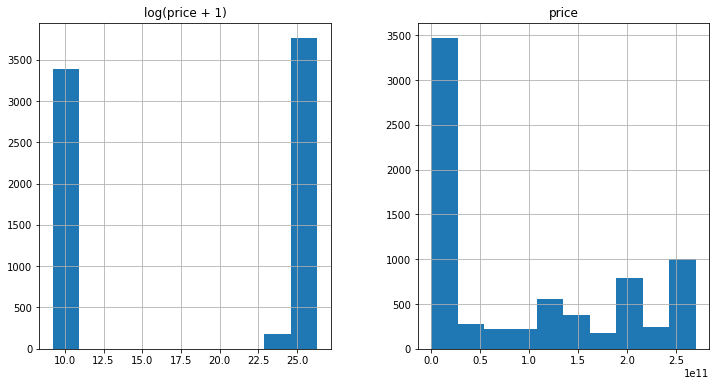

In [10]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
doacoes = pd.DataFrame({"price":points["sequencial_candidato"], "log(price + 1)":np.log1p(points["sequencial_candidato"])})
doacoes.hist()